In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

In [2]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [18]:
from sklearn.utils.class_weight import compute_sample_weight

## Transform data on Minirocket

In [3]:
file_paths = glob.glob('eeg_label/*_eeg_label.csv')

data_list = []
labels_list = []
patient_ids = []

for file_path in file_paths:
    eeg_data = pd.read_csv(file_path)
    patient_id = file_path.split('/')[-1]
    
    # Segment the data into non-overlapping 30 second windows
    segment_size = 128 * 30
    num_segments = len(eeg_data) // segment_size
    
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size
        segment = eeg_data['EEG'].iloc[start_idx:end_idx].values
        label = eeg_data['Label'].iloc[start_idx:end_idx].mode()[0]
        
        data_list.append(segment)
        labels_list.append(label)
        patient_ids.append(patient_id)  # Repeat patient ID for each segment

# Convert lists to numpy arrays
X = np.array(data_list)
y = np.array(labels_list)
patient_ids = np.array(patient_ids)

In [4]:
# Reshape to perform minirocket
X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

In [5]:
# initialise the minirocket transformer
minirocket = MiniRocket(random_state=123)
X_transformed = minirocket.fit_transform(X_reshaped) # transform the entire dataset using minirocket

# scale the transformed data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_transformed)

## XGBoost

In [6]:
# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize variables to store results
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

# Loop over each patient (Leave-One-Patient-Out)
for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y_encoded[patient_ids != patient]
    y_test = y_encoded[patient_ids == patient]
    
    # Initialize the XGBoost classifier without use_label_encoder
    xgb_classifier = xgb.XGBClassifier(eval_metric='mlogloss', random_state=2)
    
    # Train the classifier
    xgb_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = xgb_classifier.predict(X_test)
    
    # Store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)

              precision    recall  f1-score   support

          AW       0.33      0.23      0.27       155
          LA       0.38      0.28      0.32       229
          MA       0.35      0.27      0.30       327
          DA       0.61      0.71      0.65       777
          RE       0.32      0.42      0.36       186

    accuracy                           0.49      1674
   macro avg       0.40      0.38      0.38      1674
weighted avg       0.47      0.49      0.47      1674

F1 Score: 0.47
Accuracy: 0.49


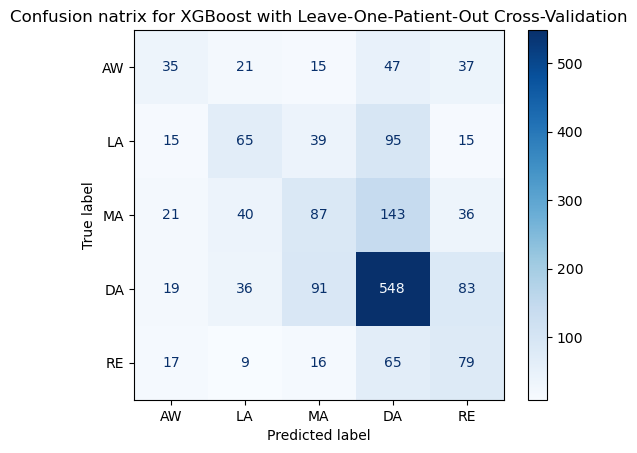

In [16]:
report = classification_report(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
print(report)

f1 = f1_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
accuracy = accuracy_score(all_labels, all_preds)
print(f'F1 Score: {f1:.2f}')
print(f'Accuracy: {accuracy:.2f}')

# generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AW', 'LA', 'MA', 'DA', 'RE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion natrix for XGBoost with Leave-One-Patient-Out Cross-Validation')
plt.show()

In [6]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [9]:
# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize variables to store results
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y_encoded[patient_ids != patient]
    y_test = y_encoded[patient_ids == patient]
    
    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Initialize the XGBoost classifier without use_label_encoder
    xgb_classifier = xgb.XGBClassifier(eval_metric='mlogloss', random_state=2)
    
    # Train the classifier on the SMOTE-applied training data
    xgb_classifier.fit(X_train_smote, y_train_smote)
    
    # Predict on the test set
    y_pred = xgb_classifier.predict(X_test)
    
    # Store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)

In [11]:
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

          AW       0.31      0.25      0.27       155
          DA       0.62      0.66      0.64       777
          LA       0.37      0.31      0.34       229
          MA       0.34      0.23      0.27       327
          RE       0.26      0.44      0.33       186

    accuracy                           0.46      1674
   macro avg       0.38      0.38      0.37      1674
weighted avg       0.46      0.46      0.46      1674



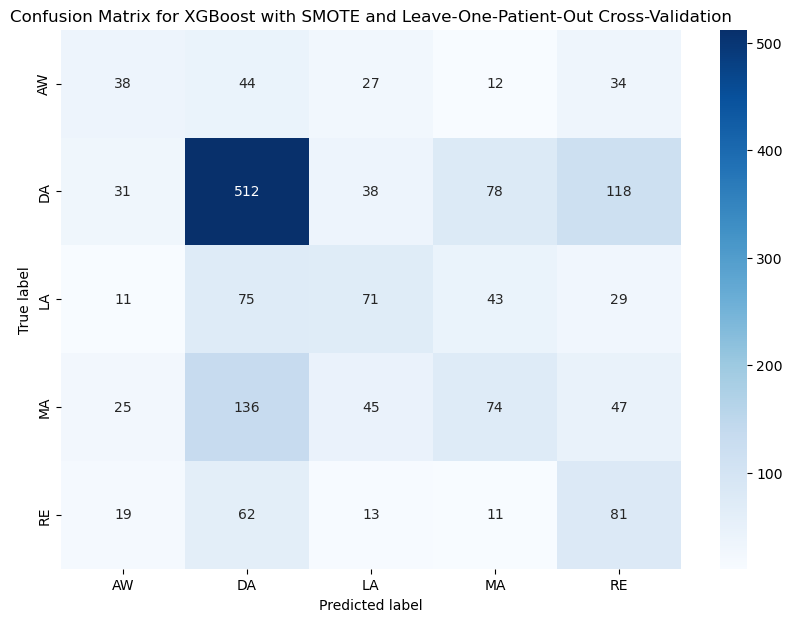

In [15]:
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XGBoost with SMOTE and Leave-One-Patient-Out Cross-Validation')
plt.show()

In [12]:
from collections import Counter

# Check the distribution of classes after SMOTE
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_smote))


Before SMOTE: Counter({1: 690, 3: 309, 2: 215, 4: 173, 0: 143})
After SMOTE: Counter({0: 690, 2: 690, 3: 690, 1: 690, 4: 690})


F1 Score (weighted): 0.46
Precision (weighted): 0.46
Recall (weighted): 0.46
Overall Accuracy: 0.46
              precision    recall  f1-score   support

          AW       0.31      0.25      0.27       155
          LA       0.37      0.31      0.34       229
          MA       0.34      0.23      0.27       327
          DA       0.62      0.66      0.64       777
          RE       0.26      0.44      0.33       186

    accuracy                           0.46      1674
   macro avg       0.38      0.38      0.37      1674
weighted avg       0.46      0.46      0.46      1674



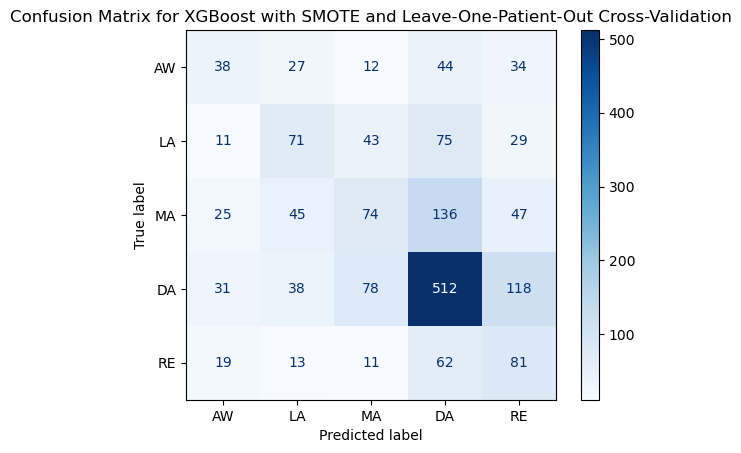

In [10]:
all_preds = label_encoder.inverse_transform(all_preds)
all_labels = label_encoder.inverse_transform(all_labels)

# Calculate F1 score, precision, recall, and accuracy
f1 = f1_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
precision = precision_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
recall = recall_score(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'], average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f'F1 Score (weighted): {f1:.2f}')
print(f'Precision (weighted): {precision:.2f}')
print(f'Recall (weighted): {recall:.2f}')
print(f'Overall Accuracy: {accuracy:.2f}')

# Optionally, print the full classification report
report = classification_report(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])
print(report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=['AW', 'LA', 'MA', 'DA', 'RE'])

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AW', 'LA', 'MA', 'DA', 'RE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost with SMOTE and Leave-One-Patient-Out Cross-Validation')
plt.show()

In [ ]:
distribution of each anaesthesia class vs prob of xgboost output

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

f1_scorer = make_scorer(f1_score, average='weighted')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=2),
    param_grid,
    scoring=f1_scorer,
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Set to 1 to see progress; set to 0 for no output
    n_jobs=-1  # Use all available cores
)

# Perform Leave-One-Patient-Out Cross-Validation
all_preds = []
all_labels = []
all_patient_ids = np.unique(patient_ids)

for patient in all_patient_ids:
    # Split the data based on patient IDs
    X_train = X_scaled[patient_ids != patient]
    X_test = X_scaled[patient_ids == patient]
    y_train = y_encoded[patient_ids != patient]
    y_test = y_encoded[patient_ids == patient]
    
    # Fit the GridSearchCV object on the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test)
    
    # Store the results
    all_preds.extend(y_pred)
    all_labels.extend(y_test)

# Calculate the F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Weighted F1 Score: {f1}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Weighted F1 Score: 0.452514579120707


In [21]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1}')

Weighted F1 Score: 0.44880572957526993
